<a href="https://colab.research.google.com/github/rcbusinesstechlab/realtime-face-recognition/blob/main/Kan_model_graphs_synthetic_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/50 | Train Loss: 0.7712 | Val Loss: 0.7050 | Val Dice: 0.2226
Epoch 2/50 | Train Loss: 0.7611 | Val Loss: 0.7176 | Val Dice: 0.2975
Epoch 3/50 | Train Loss: 0.7583 | Val Loss: 0.7318 | Val Dice: 0.3278
Epoch 4/50 | Train Loss: 0.7557 | Val Loss: 0.7436 | Val Dice: 0.3439
Epoch 5/50 | Train Loss: 0.7532 | Val Loss: 0.7493 | Val Dice: 0.3552
Epoch 6/50 | Train Loss: 0.7507 | Val Loss: 0.7529 | Val Dice: 0.3642
Epoch 7/50 | Train Loss: 0.7483 | Val Loss: 0.7563 | Val Dice: 0.3726
Epoch 8/50 | Train Loss: 0.7460 | Val Loss: 0.7577 | Val Dice: 0.3798
Epoch 9/50 | Train Loss: 0.7438 | Val Loss: 0.7546 | Val Dice: 0.3869
Epoch 10/50 | Train Loss: 0.7416 | Val Loss: 0.7511 | Val Dice: 0.3941
Epoch 11/50 | Train Loss: 0.7396 | Val Loss: 0.7469 | Val Dice: 0.4006
Epoch 12/50 | Train Loss: 0.7375 | Val Loss: 0.7433 | Val Dice: 0.4071
Epoch 13/50 | Train Loss: 0.7356 | Val Loss: 0.7399 | Val Dice: 0.4129
Epoch 14/50 | Train Loss: 0.7337 | Val Loss: 0.7372 | Val Dice: 0.4189
Epoch 15/50 | T

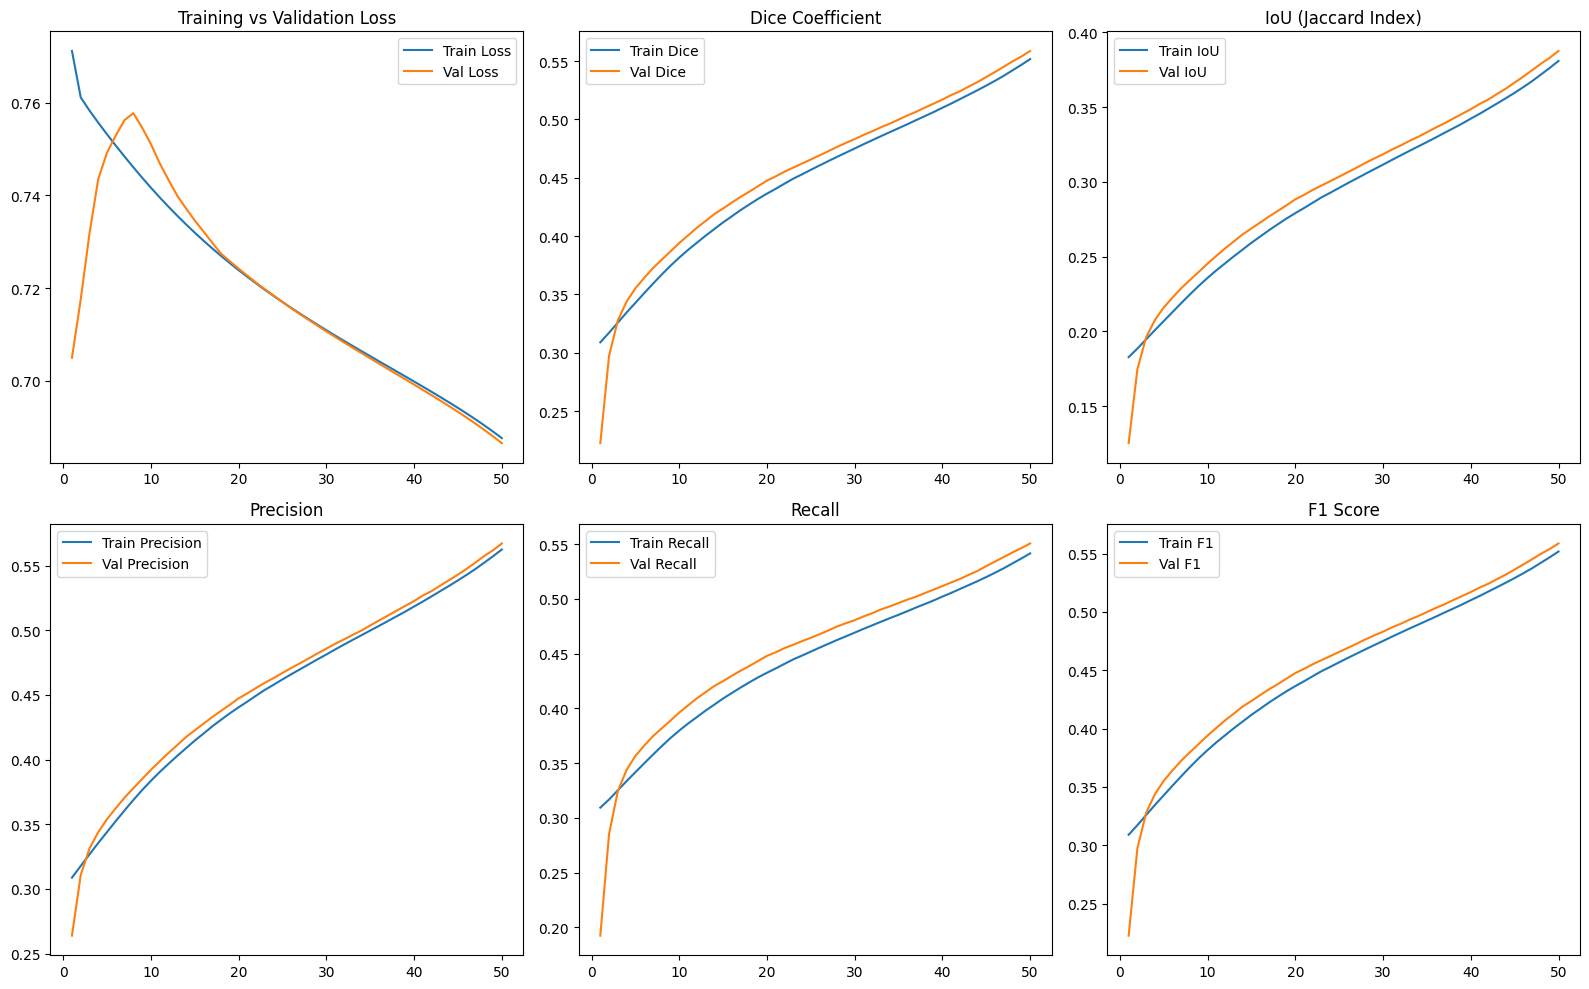

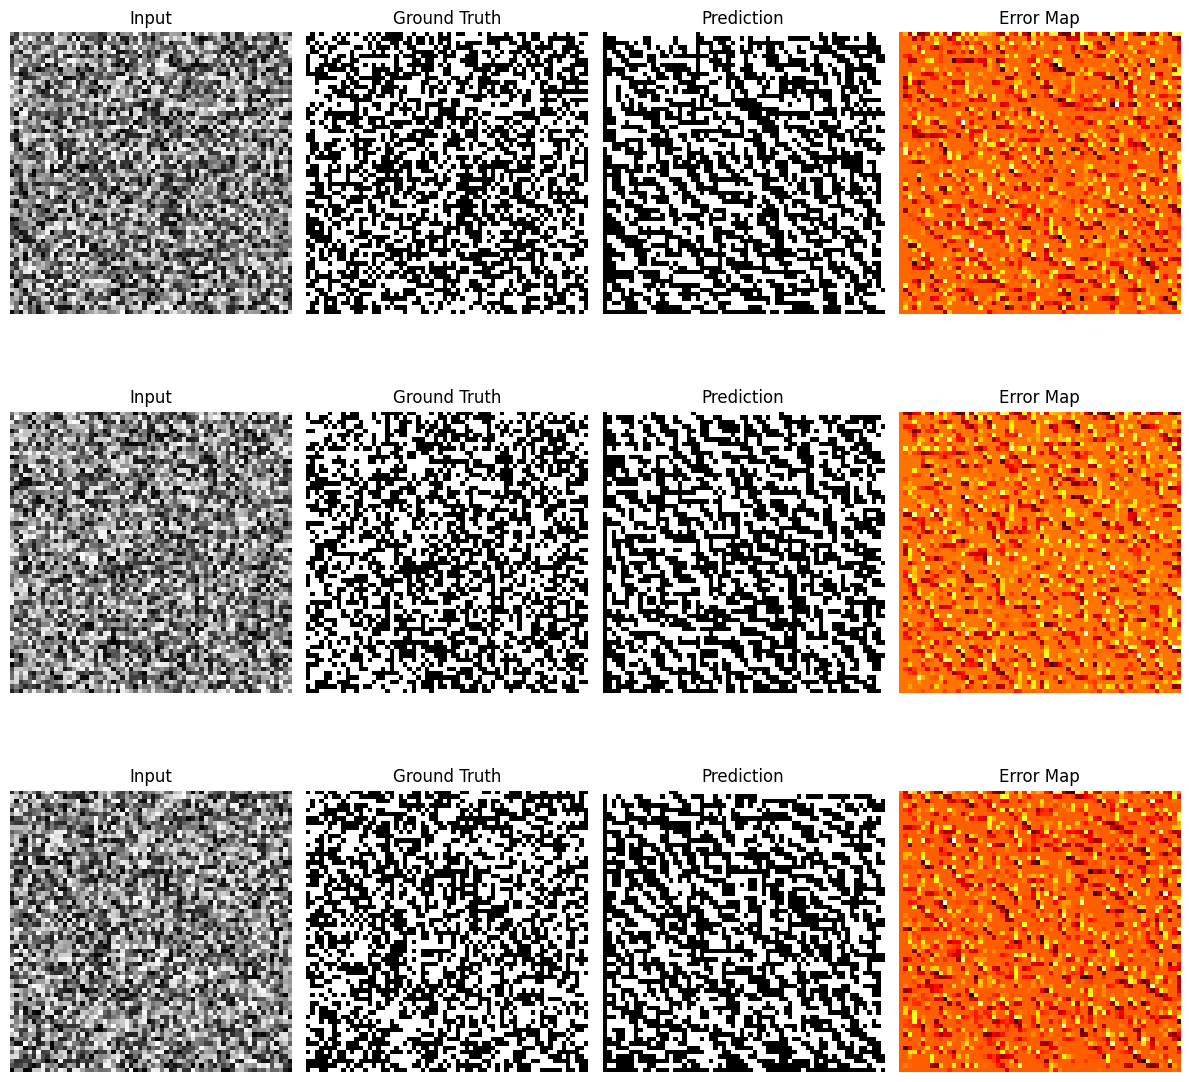

In [4]:
import torch
import torch.nn as nn
import numpy as np
from scipy.spatial.distance import directed_hausdorff
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc

# ─── Spline Basis ─────────────────────────────────────────────
class SplineBasis(nn.Module):
    def __init__(self, num_basis=16, domain=(-1.0, 1.0)):
        super().__init__()
        self.num_basis = num_basis
        self.domain = domain
        self.register_buffer('knots', torch.linspace(domain[0], domain[1], num_basis))

    def forward(self, x):
        x = x.unsqueeze(-1)
        distances = torch.abs(x - self.knots)
        basis = torch.clamp(1 - distances * self.num_basis, min=0)
        return basis

# ─── KAN Layer 1D ─────────────────────────────────────────────
class KANLayer1D(nn.Module):
    def __init__(self, in_channels, out_channels, num_basis=16):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.num_basis = num_basis
        self.spline = SplineBasis(num_basis)
        self.coeffs = nn.Parameter(torch.randn(out_channels, in_channels, num_basis))

    def forward(self, x):
        basis_vals = self.spline(x)  # (batch, in_channels, num_basis)
        out = torch.einsum('bic,oic->bo', basis_vals, self.coeffs)
        return out

# ─── KAN-Enhanced SE Block ───────────────────────────────────
class KANSEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16, num_basis=16):
        super().__init__()
        mid_channels = max(1, in_channels // reduction)
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.kan1 = KANLayer1D(in_channels, mid_channels, num_basis)
        self.kan2 = KANLayer1D(mid_channels, in_channels, num_basis)
        self.activation = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        B, C, H, W = x.shape
        z = self.global_pool(x).view(B, C)
        h = self.activation(self.kan1(z))
        s = self.sigmoid(self.kan2(h)).view(B, C, 1, 1)
        return x * s

# ─── Example CNN Using KANSEBlock ─────────────────────────────
class SampleKANUNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            KANSEBlock(out_channels)
        )

    def forward(self, x):
        return self.conv(x)

# ─── Metrics ───────────────────────────────────────────────────
def dice_coefficient(pred, target, epsilon=1e-6):
    pred = (pred > 0.5).float()
    target = (target > 0.5).float()
    intersection = (pred * target).sum(dim=(2,3))
    union = pred.sum(dim=(2,3)) + target.sum(dim=(2,3))
    dice = (2.*intersection + epsilon) / (union + epsilon)
    return dice.mean().item()

def iou_score(pred, target, epsilon=1e-6):
    pred = (pred > 0.5).float()
    target = (target > 0.5).float()
    intersection = (pred * target).sum(dim=(2,3))
    union = (pred + target - pred*target).sum(dim=(2,3))
    iou = (intersection + epsilon) / (union + epsilon)
    return iou.mean().item()

def precision_recall_f1(pred, target):
    # flatten tensors
    pred = (pred > 0.5).view(-1).cpu().numpy()
    target = (target > 0.5).view(-1).cpu().numpy()
    precision, recall, f1, _ = precision_recall_fscore_support(target, pred, average='binary', zero_division=0)
    return precision, recall, f1

def plot_metrics(history):
    epochs = range(1, len(history['train_loss'])+1)

    plt.figure(figsize=(16,10))

    # Loss
    plt.subplot(2,3,1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()

    # Dice
    plt.subplot(2,3,2)
    plt.plot(epochs, history['train_dice'], label='Train Dice')
    plt.plot(epochs, history['val_dice'], label='Val Dice')
    plt.title('Dice Coefficient')
    plt.legend()

    # IoU
    plt.subplot(2,3,3)
    plt.plot(epochs, history['train_iou'], label='Train IoU')
    plt.plot(epochs, history['val_iou'], label='Val IoU')
    plt.title('IoU (Jaccard Index)')
    plt.legend()

    # Precision
    plt.subplot(2,3,4)
    plt.plot(epochs, history['train_precision'], label='Train Precision')
    plt.plot(epochs, history['val_precision'], label='Val Precision')
    plt.title('Precision')
    plt.legend()

    # Recall
    plt.subplot(2,3,5)
    plt.plot(epochs, history['train_recall'], label='Train Recall')
    plt.plot(epochs, history['val_recall'], label='Val Recall')
    plt.title('Recall')
    plt.legend()

    # F1 Score
    plt.subplot(2,3,6)
    plt.plot(epochs, history['train_f1'], label='Train F1')
    plt.plot(epochs, history['val_f1'], label='Val F1')
    plt.title('F1 Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_images(inputs, gts, preds, error_maps, n=3):
    plt.figure(figsize=(12, 4*n))
    for i in range(n):
        # Input
        plt.subplot(n,4,4*i+1)
        plt.imshow(inputs[i].squeeze().cpu(), cmap='gray')
        plt.title('Input')
        plt.axis('off')

        # Ground Truth
        plt.subplot(n,4,4*i+2)
        plt.imshow(gts[i].squeeze().cpu(), cmap='gray')
        plt.title('Ground Truth')
        plt.axis('off')

        # Prediction
        plt.subplot(n,4,4*i+3)
        plt.imshow(preds[i].squeeze().cpu(), cmap='gray')
        plt.title('Prediction')
        plt.axis('off')

        # Error map
        plt.subplot(n,4,4*i+4)
        plt.imshow(error_maps[i].squeeze().cpu(), cmap='hot')
        plt.title('Error Map')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# ─── Training Loop with Validation ────────────────────────────
def train_validate_model(model, train_loader, val_loader, optimizer, criterion, num_epochs=100, device='cpu'):
    history = {
        'train_loss': [], 'val_loss': [],
        'train_dice': [], 'val_dice': [],
        'train_iou': [], 'val_iou': [],
        'train_precision': [], 'val_precision': [],
        'train_recall': [], 'val_recall': [],
        'train_f1': [], 'val_f1': []
    }
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        train_losses, train_dices, train_ious = [], [], []
        train_precisions, train_recalls, train_f1s = [], [], []

        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            probs = torch.sigmoid(outputs)
            train_losses.append(loss.item())
            train_dices.append(dice_coefficient(probs, masks))
            train_ious.append(iou_score(probs, masks))
            p, r, f1 = precision_recall_f1(probs, masks)
            train_precisions.append(p)
            train_recalls.append(r)
            train_f1s.append(f1)

        # Validation
        model.eval()
        val_losses, val_dices, val_ious = [], [], []
        val_precisions, val_recalls, val_f1s = [], [], []

        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                probs = torch.sigmoid(outputs)

                val_losses.append(loss.item())
                val_dices.append(dice_coefficient(probs, masks))
                val_ious.append(iou_score(probs, masks))
                p, r, f1 = precision_recall_f1(probs, masks)
                val_precisions.append(p)
                val_recalls.append(r)
                val_f1s.append(f1)

        # Save epoch metrics
        history['train_loss'].append(np.mean(train_losses))
        history['val_loss'].append(np.mean(val_losses))

        history['train_dice'].append(np.mean(train_dices))
        history['val_dice'].append(np.mean(val_dices))

        history['train_iou'].append(np.mean(train_ious))
        history['val_iou'].append(np.mean(val_ious))

        history['train_precision'].append(np.mean(train_precisions))
        history['val_precision'].append(np.mean(val_precisions))

        history['train_recall'].append(np.mean(train_recalls))
        history['val_recall'].append(np.mean(val_recalls))

        history['train_f1'].append(np.mean(train_f1s))
        history['val_f1'].append(np.mean(val_f1s))

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {history['train_loss'][-1]:.4f} | Val Loss: {history['val_loss'][-1]:.4f} | Val Dice: {history['val_dice'][-1]:.4f}")

    return model, history

# ─── Main execution ───────────────────────────────────────────
if __name__ == "__main__":
    # Synthetic data
    images = torch.rand(100,1,64,64)
    masks = (images > 0.5).float()

    dataset = TensorDataset(images, masks)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_ds, val_ds = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=8)

    model = SampleKANUNetBlock(in_channels=1, out_channels=1)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.BCEWithLogitsLoss()

    model, history = train_validate_model(model, train_loader, val_loader, optimizer, criterion, num_epochs=50)

    plot_metrics(history)

    # Show examples with error maps
    model.eval()
    with torch.no_grad():
        for imgs, gt_masks in val_loader:
            imgs, gt_masks = imgs.to('cpu'), gt_masks.to('cpu')
            preds = torch.sigmoid(model(imgs))
            error_maps = torch.abs(preds - gt_masks)
            plot_images(imgs, gt_masks, (preds > 0.5).float(), error_maps)
            break
